## Model Train 1 - Tesis Javier-Uriel

### Importamos algunas librerías que nos serán útiles más adelante

In [1]:
import os
import json
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv

import tensorflow as tf
from tensorflow.keras import models, layers
assert (tf.__version__=='2.4.1'), 'Versión incorrecta de Tensorflow, por favor instale 2.4.1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from IPython.display import clear_output

pd.set_option('display.max_columns', None) #Para mostrar todas las columnas

import gc #garbage collector
import gc; gc.enable()

Num GPUs Available:  1


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


### Leemos el Dataset

In [3]:
#Dataset solo movimientos en Z
rpm_list = ['RPM0', 'RPM1', 'RPM2', 'RPM3']
# states_list_org = ["vx","ax", "uvx", 
#                    "vy","ay", "uvy", 
#                    "vz","az", "uvz", 
#                     "p", "q", "r",
#                     "wp", "wq", "wr",
#                     "ap", "aq", "ar"]
states_list_org = ["vz","az", "uvz",
                "p", "q",
                "wp", "wq", 
                "ap", "aq"]
dataset_name = "Dataset_Z"#"Dataset_Z7_Disturbance_Z"
directory = "../logs/Datasets/"+dataset_name
ORDER = 3
dfs = []
states_list=states_list_org.copy()

In [4]:
for filename in os.listdir(directory):
    if not filename.endswith(".csv"):
        continue
    df = pd.read_csv(os.path.join(directory, filename))
    a = []
    ## Desplazamos estados anteriores        
    for n in range(1,ORDER+1):
        for column in states_list:
            df[column+str(n)] = df[column].shift(periods=n, fill_value=0)
            a.append(column+str(n))
    dfs.append(df)
states_list+=a        
        
dataset = pd.concat(dfs)
dataset.head()

,timestamps,x,y,z,Q1,Q2,Q3,Q4,p,q,r,vx,vy,vz,wp,wq,wr,ax,ay,az,ap,aq,ar,RPM0,RPM1,RPM2,RPM3,ux,uy,uz,uvx,uvy,uvz,up,uq,ur,uwp,uwq,uwr,vz1,az1,uvz1,p1,q1,wp1,wq1,ap1,aq1,vz2,az2,uvz2,p2,q2,wp2,wq2,ap2,aq2,vz3,az3,uvz3,p3,q3,wp3,wq3,ap3,aq3
0,0.000000,0.0,0.0,49.999830,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.040833,0.0,0.0,0.0,0.0,0.0,-9.800000,0.0,0.0,0.0,15016.253501,15016.253501,15016.253501,15016.253501,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.004167,0.0,0.0,49.999673,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.037676,0.0,0.0,0.0,0.0,0.0,0.757873,0.0,0.0,0.0,15016.253501,15016.253501,15016.253501,15016.253501,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.040833,-9.800000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.008333,0.0,0.0,49.999529,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.034518,0.0,0.0,0.0,0.0,0.0,0.757737,0.0,0.0,0.0,15016.253501,15016.253501,15016.253501,15016.253501,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.037676,0.757873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.040833,-9.800000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.012500,0.0,0.0,49.999398,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.031362,0.0,0.0,0.0,0.0,0.0,0.757601,0.0,0.0,0.0,15016.253501,15016.253501,15016.253501,15016.253501,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.034518,0.757737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.037676,0.757873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.040833,-9.800000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.016667,0.0,0.0,49.999281,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.028206,0.0,0.0,0.0,0.0,0.0,0.757467,0.0,0.0,0.0,15016.253501,15016.253501,15016.253501,15016.253501,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.031362,0.757601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.034518,0.757737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.037676,0.757873,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Estados repetidos

En este caso se eliminan estados repetidos y estados que se encuentren en estado transitorio mientras el dron despega o se estabiliza antes de introducir la señal de control.

In [5]:
shape_b4 = dataset.drop(["timestamps"], axis=1).shape
shape_drop= dataset.drop(["timestamps"], axis=1).drop_duplicates().shape
print(f'shape (b4 drop) = {shape_b4}')
print(f'shape = {shape_drop}')
print(f'len (b4 drop) - len = {shape_b4[0]-shape_drop[0]}')

shape (b4 drop) = (3119870, 65)
shape = (3057400, 65)
len (b4 drop) - len = 62470


### División del dataset en estados y acciones

In [6]:
actions = dataset.drop(["timestamps"], axis=1).drop_duplicates()[rpm_list]
print(f'columns = {actions.columns}')
print(f'shape = {actions.shape}')
actions.head()

columns = Index(['RPM0', 'RPM1', 'RPM2', 'RPM3'], dtype='object')
shape = (3057400, 4)


,RPM0,RPM1,RPM2,RPM3
0,15016.253501,15016.253501,15016.253501,15016.253501
1,15016.253501,15016.253501,15016.253501,15016.253501
2,15016.253501,15016.253501,15016.253501,15016.253501
3,15016.253501,15016.253501,15016.253501,15016.253501
4,15016.253501,15016.253501,15016.253501,15016.253501


#### Normalización de acciones

In [7]:
def normalize_df(df, K=21666.4475, B = 9440.3):#B=14468.4292):
    df_norm = (actions-B)/(K-B)
    return df_norm, K-B, B

In [8]:
actions, K, B = normalize_df(actions)
actions.describe()

,RPM0,RPM1,RPM2,RPM3
count,3.057400e+06,3.057400e+06,3.057400e+06,3.057400e+06
mean,4.058453e-01,4.058412e-01,4.058459e-01,4.058441e-01
std,1.119014e-01,1.119445e-01,1.118949e-01,1.119143e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.101885e-01,4.101885e-01,4.101885e-01,4.101885e-01
50%,4.112603e-01,4.112603e-01,4.112603e-01,4.112603e-01
75%,4.120285e-01,4.120360e-01,4.120466e-01,4.120565e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [9]:
print(K)

12226.1475


#### Definimos los estados

In [10]:
states = dataset.drop(["timestamps"], axis=1).drop_duplicates()[states_list]
print(f'columns = {states.columns}')
print(f'shape = {states.shape}')
states.describe()

columns = Index(['vz', 'az', 'uvz', 'p', 'q', 'wp', 'wq', 'ap', 'aq', 'vz1', 'az1',
       'uvz1', 'p1', 'q1', 'wp1', 'wq1', 'ap1', 'aq1', 'vz2', 'az2', 'uvz2',
       'p2', 'q2', 'wp2', 'wq2', 'ap2', 'aq2', 'vz3', 'az3', 'uvz3', 'p3',
       'q3', 'wp3', 'wq3', 'ap3', 'aq3'],
      dtype='object')
shape = (3057400, 36)


,vz,az,uvz,p,q,wp,wq,ap,aq,vz1,az1,uvz1,p1,q1,wp1,wq1,ap1,aq1,vz2,az2,uvz2,p2,q2,wp2,wq2,ap2,aq2,vz3,az3,uvz3,p3,q3,wp3,wq3,ap3,aq3
count,3.057400e+06,3.057400e+06,3.057400e+06,3.057400e+06,3.057400e+06,3.057400e+06,3.057400e+06,3.057400e+06,3.057400e+06,3.057400e+06,3.057400e+06,3.057400e+06,3.057400e+06,3.057400e+06,3.057400e+06,3.057400e+06,3.057400e+06,3.057400e+06,3.057400e+06,3.057400e+06,3.057400e+06,3.057400e+06,3.057400e+06,3.057400e+06,3.057400e+06,3.057400e+06,3.057400e+06,3.057400e+06,3.057400e+06,3.057400e+06,3.057400e+06,3.057400e+06,3.057400e+06,3.057400e+06,3.057400e+06,3.057400e+06
mean,-9.603269e-03,-3.062878e-03,-2.755897e-02,-4.629272e-05,2.959225e-06,-1.873690e-06,2.809163e-07,4.187102e-11,-6.042911e-10,-9.590507e-03,-3.062878e-03,-2.754612e-02,-4.629272e-05,2.959226e-06,-1.873690e-06,2.809188e-07,1.738866e-11,-6.777653e-10,-9.577745e-03,-3.062878e-03,-2.753327e-02,-4.629272e-05,2.959227e-06,-1.873690e-06,2.809216e-07,-7.097781e-12,-7.512518e-10,-9.564983e-03,-3.062878e-03,-2.752043e-02,-4.629272e-05,2.959228e-06,-1.873690e-06,2.809247e-07,-3.158830e-11,-8.247504e-10
std,7.131704e-01,1.894747e+00,7.492675e-01,1.860276e-02,1.834278e-02,1.138716e-01,1.127022e-01,1.880478e+00,1.868320e+00,7.131368e-01,1.894747e+00,7.492353e-01,1.860276e-02,1.834278e-02,1.138716e-01,1.127022e-01,1.880478e+00,1.868320e+00,7.131032e-01,1.894747e+00,7.492032e-01,1.860276e-02,1.834278e-02,1.138716e-01,1.127022e-01,1.880478e+00,1.868320e+00,7.130696e-01,1.894747e+00,7.491710e-01,1.860276e-02,1.834278e-02,1.138716e-01,1.127022e-01,1.880478e+00,1.868320e+00
min,-5.929732e+00,-9.800000e+00,-5.576059e+00,-1.995813e-01,-2.997654e-01,-2.101633e+00,-2.665827e+00,-1.709116e+01,-1.747593e+01,-5.929732e+00,-9.800000e+00,-5.576059e+00,-1.995813e-01,-2.997654e-01,-2.101633e+00,-2.665827e+00,-1.709116e+01,-1.747593e+01,-5.929732e+00,-9.800000e+00,-5.576059e+00,-1.995813e-01,-2.997654e-01,-2.101633e+00,-2.665827e+00,-1.709116e+01,-1.747593e+01,-5.929732e+00,-9.800000e+00,-5.576059e+00,-1.995813e-01,-2.997654e-01,-2.101633e+00,-2.665827e+00,-1.709116e+01,-1.747593e+01
25%,-8.365745e-02,-1.099408e-05,-5.181916e-02,-3.263776e-08,-3.124422e-08,-2.096816e-07,-2.024922e-07,-1.668252e-06,-1.600643e-06,-8.365742e-02,-1.099237e-05,-5.181916e-02,-3.263284e-08,-3.123810e-08,-2.096587e-07,-2.024850e-07,-1.667917e-06,-1.600504e-06,-8.364806e-02,-1.099198e-05,-5.181916e-02,-3.262791e-08,-3.123309e-08,-2.096328e-07,-2.024829e-07,-1.667620e-06,-1.600415e-06,-8.356966e-02,-1.099144e-05,-5.181916e-02,-3.262330e-08,-3.122341e-08,-2.095903e-07,-2.024767e-07,-1.667336e-06,-1.600299e-06
50%,-2.057265e-13,2.055969e-15,0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.048708e-13,2.055969e-15,0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.039181e-13,2.055969e-15,0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.032162e-13,2.055969e-15,0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.387919e-02,1.540782e-05,0.000000e+00,3.229031e-08,3.150770e-08,2.185427e-07,2.103635e-07,1.673496e-06,1.635888e-06,5.387919e-02,1.540782e-05,0.000000e+00,3.228036e-08,3.150135e-08,2.185151e-07,2.103511e-07,1.673218e-06,1.635664e-06,5.387918e-02,1.540782e-05,0.000000e+00,3.227452e-08,3.149185e-08,2.185033e-07,2.103396e-07,1.672907e-06,1.635409e-06,5.387914e-02,1.540782e-05,0.000000e+00,3.226646e-08,3.148500e-08,2.184955e-07,2.103317e-07,1.672722e-06,1.635195e-06
max,5.513385e+00,1.360506e+01,5.306947e+00,2.562534e-01,2.628159e-01,1.999274e+00,2.402572e+00,1.703074e+01,1.789195e+01,5.513385e+00,1.360506e+01,5.306947e+00,2.562534e-01,2.628159e-01,1.999274e+00,2.402572e+00,1.703074e+01,1.789195e+01,5.513385e+00,1.360506e+01,5.306947e+00,2.562534e-01,2.628159e-01,1.999274e+00,2.402572e+00,1.703074e+01,1.789195e+01,5.513385e+00,1.360506e+01,5.306947e+00,2.562534e-01,2.628159e-01,1.999274e+00,2.402572e+00,1.703074e

In [11]:
del dataset

### Dividimos el dataset

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(states, actions, test_size=0.1)
ins = states.shape[1]
outs = actions.shape[1]
del states, actions

## Keras Model

#### Early Stopping

In [13]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

#### Plotting

In [14]:
class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.yscale('log')
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

#### Definición del Modelo

In [15]:
inputs = tf.keras.Input(shape=(ins,))
x = tf.keras.layers.Dense(int(4*ins), activation=tf.nn.tanh)(inputs)
x = tf.keras.layers.Dense(int(2*ins), activation=tf.nn.tanh)(x)
#x = tf.keras.layers.Dense(int(2*ins), activation=tf.nn.relu)(x)
outputs = tf.keras.layers.Dense(outs, activation=tf.nn.relu)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

#### Compilado el Modelo

In [16]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mean_squared_error'])

#### Entrenamiento del Modelo

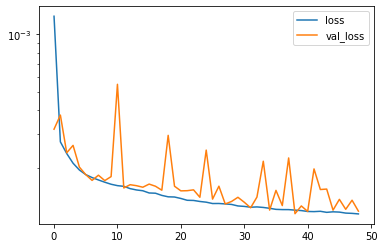

Wall time: 12min 42s


In [17]:
%%time
model.fit(X_train, Y_train, validation_split=0.3, epochs=100, batch_size=512, callbacks=[callback, plot_losses])

#### Evaluación del Modelo

In [18]:
loss, mean_sq = model.evaluate(X_test, Y_test)
print(f'mean_sq: {mean_sq} -> {np.sqrt(mean_sq)*K} RPM')
print(f'loss: {loss} -> {loss*K} RPM')

9555/9555 [==============================] - 21s 2ms/step - loss: 1.1335e-04 - mean_squared_error: 1.1335e-04
mean_sq: 0.00011334671580698341 -> 130.1649636663597 RPM
loss: 0.00011334671580698341 -> 1.3857936660967607 RPM


#### Se guarda el Modelo

In [19]:
I = 'Pandas'
model.save(f'../Models/{dataset_name}_{I}.h5')

In [20]:
model = tf.keras.models.load_model(f'../Models/{dataset_name}_{I}.h5')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 36)]              0         
_________________________________________________________________
dense (Dense)                (None, 144)               5328      
_________________________________________________________________
dense_1 (Dense)              (None, 72)                10440     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 292       
Total params: 16,060
Trainable params: 16,060
Non-trainable params: 0
_________________________________________________________________


In [21]:
%%time
x_test = X_test.sample(n=10, random_state=1)
for index, sample in x_test.iterrows():
    print(model.predict([list(sample)])*K+B)

[[9440.3 9440.3 9440.3 9440.3]]
[[14464.402 14475.139 14477.91  14470.89 ]]
[[14529.361 14525.014 14538.193 14533.824]]
[[14429.596 14456.892 14458.619 14450.058]]
[[14455.758 14477.295 14475.311 14467.648]]
[[14969.027 14239.814 14346.261 14947.051]]
[[14562.462 14556.136 14573.097 14571.909]]
[[15317.668 15272.447 15312.461 15299.036]]
[[16683.53  17070.434 16237.871 15860.314]]
[[14409.096 14442.838 14440.316 14432.908]]
Wall time: 528 ms


In [22]:
%%time
x_test = [0]*len(states_list)
x_test[0] = -0.04083333
x_test[1] = -9.8
x_test[2] = 0
print(model.predict([list(x_test)])*K+B)

[[15260.955 15309.541 15291.601 15232.392]]
Wall time: 53 ms


In [23]:
# x_test = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.04083333333333333, -9.8, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# print(model.predict([list(x_test)]))
# print(model.predict([list(x_test)])*K+B)